In [59]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, TimeSeriesSplit
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, make_scorer
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from helper import ResidualBoostClassifier as RBC

# Unidad Energía,GWh,,,,,,,,, for sp_forecasting_test

# Data Cleaning

In [73]:
df = pd.read_csv('Input Data.csv')

# 2) Normalize the column names
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(' ', '_')
)

# 3) Parse your date
df['date'] = pd.to_datetime(df['row_labels'], errors='coerce')

# 3) Convert percentage column
df['reservoir_inflows_per'] = (pd.to_numeric(df['reservoir_inflows_per'].str.rstrip(' %'), errors='coerce') / 100)

# Clean numeric columns
num_cols = [
    'electric_demand',
    'reservoir_inflows_gwh',
    'reservoir_gwh',
    'energy_dumping_gwh',
    'cere_copkwh',
    'spot_price_copkwh',
    'scarcity_price_copkwh',
    'thermo_transport_cost_copkwh',
    'thermo_supply_cost_copkwh'
]
for c in num_cols:
    df[c] = pd.to_numeric(df[c].astype(str).str.replace(',', '', regex=False), errors='coerce')

# 5)  Drop unused and duplicate rows
df = df.drop(columns=['row_labels']).drop_duplicates()

# 6) Sort by date
df = df.sort_values('date')

# 7) Set date as index
df.set_index('date', inplace=True)

Create DF

In [74]:
# Setting it up

# Lag target and exogenous variables
lags = [1, 3, 7]

for lag in lags:
    df[f'spot_lag_{lag}'] = df['spot_price_copkwh'].shift(lag)
    df[f'reservoir_gwh_lag{lag}'] = df['reservoir_gwh'].shift(lag)
    df[f'reservoir_inflows_gwh_lag{lag}'] = df['reservoir_inflows_gwh'].shift(lag)

# Drop rows with any NaNs resulting from shifts
df_model = df.dropna(subset=[f'spot_lag_{lag}' for lag in lags] +
                               [f'reservoir_gwh_lag{lag}' for lag in lags] +
                               [f'reservoir_inflows_gwh_lag{lag}' for lag in lags] +
                               ['spot_price_copkwh'])

# Define feature set
feature_cols = [f'spot_lag_{lag}' for lag in lags] + \
               [f'reservoir_gwh_lag{lag}' for lag in lags] + \
               [f'reservoir_inflows_gwh_lag{lag}' for lag in lags]

X = df_model[feature_cols]
y = df_model['spot_price_copkwh']


# RANDOM FOREST

Test RMSE: 108.14


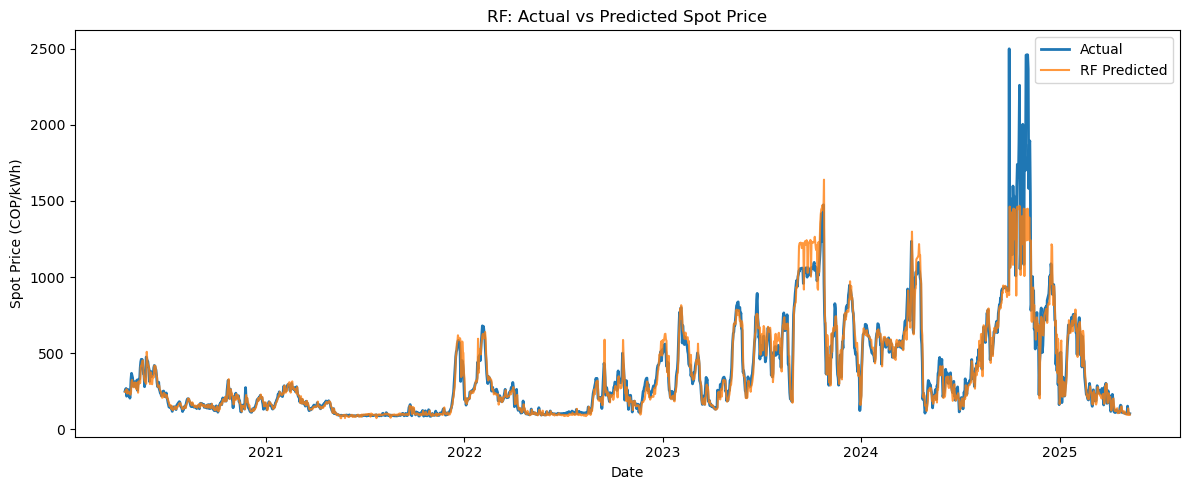

In [75]:
# 80/20 time-based split
split_idx = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_test = X_test.index

# 5) train RF & eval
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.2f}")

# 6) plot actual vs. predicted
plt.figure(figsize=(12,5))
plt.plot(dates_test, y_test, label='Actual', linewidth=2)
plt.plot(dates_test, y_pred, label='RF Predicted', alpha=0.8)
plt.legend()
plt.title('RF: Actual vs Predicted Spot Price')
plt.xlabel('Date')
plt.ylabel('Spot Price (COP/kWh)')
plt.tight_layout()
plt.show()

# XGBOOST and RF

RF 2025 Test RMSE: 62.72
XGB 2025 Test RMSE: 59.79
XGB SMAPE: 13.72%
XGB MASE: 1.106


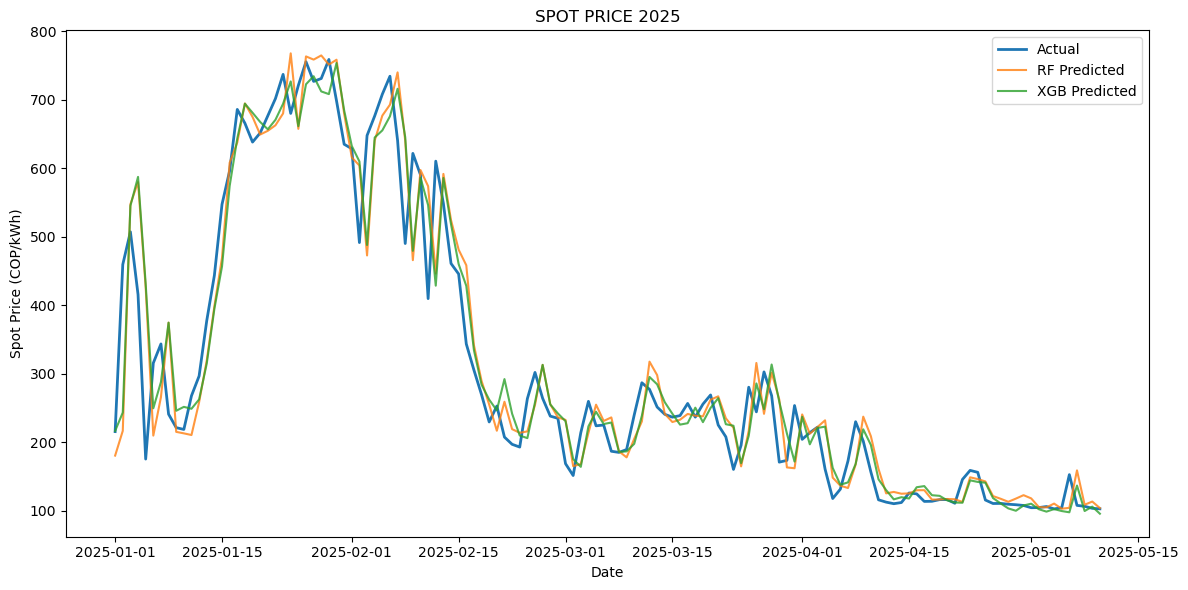

In [79]:
df_model.index = pd.to_datetime(df_model.index)

# 1) Select your train / test years
train = df_model[(df_model.index.year >= 2020) & (df_model.index.year <= 2024)]
test  = df_model[df_model.index.year == 2025]

X_train = train[feature_cols]
y_train = train['spot_price_copkwh']
X_test  = test[feature_cols]
y_test  = test['spot_price_copkwh']
dates   = test.index

# 2) Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
print(f"RF 2025 Test RMSE: {rmse_rf:.2f}")

# 3) XGBoost
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)
print(f"XGB 2025 Test RMSE: {rmse_xgb:.2f}")

# SMAPE ERROR
def smape(y_true, y_pred):
    num = np.abs(y_pred - y_true)
    den = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean( num/den ) * 100

smape_xgb = smape(y_test.values, y_pred_xgb)
print(f"XGB SMAPE: {smape_xgb:.2f}%")

# MASE ERROR
def mase(y_true, y_pred, y_train):
    mae_model = np.abs(y_true - y_pred).mean()
    mae_naive = np.abs(np.diff(y_train)).mean()
    return mae_model / mae_naive

mase_xgb = mase(y_test.values, y_pred_xgb, y_train.values)
print(f"XGB MASE: {mase_xgb:.3f}")

# 4) Plot actual vs both predictions
plt.figure(figsize=(12,6))
plt.plot(dates, y_test, label='Actual', linewidth=2)
plt.plot(dates, y_pred_rf, label='RF Predicted', alpha=0.8)
plt.plot(dates, y_pred_xgb, label='XGB Predicted', alpha=0.8)
plt.legend()
plt.title('SPOT PRICE 2025')
plt.xlabel('Date')
plt.ylabel('Spot Price (COP/kWh)')
plt.tight_layout()
plt.show()

SMAPE ≈ 13.5 %
You’re off by about 13.5 % on average, symmetrically. That’s…okay – in some markets you’d kill for that, but with prices that often dip near zero it still means big swings when the denominator is tiny.

MASE ≈ 1.10
Since MASE > 1, your XGB model is actually about 10 % worse than the naïve “yesterday’s price” forecast (on average). Oof—definitely room to improve.

In [80]:
clf = RBC(
    base_reg    = RandomForestRegressor(n_estimators=100, random_state=42),
    residual_reg= XGBRegressor(n_estimators=100, random_state=42)
)

clf.fit(X_train, y_train)

# 2) Predict on your 2025 test set
y_pred = clf.predict(X_test)

# 3) Compute RMSE correctly
rmse = root_mean_squared_error(y_test, y_pred)
print(f"2025 Test RMSE (RBC): {rmse:.2f}")

2025 Test RMSE (RBC): 63.07


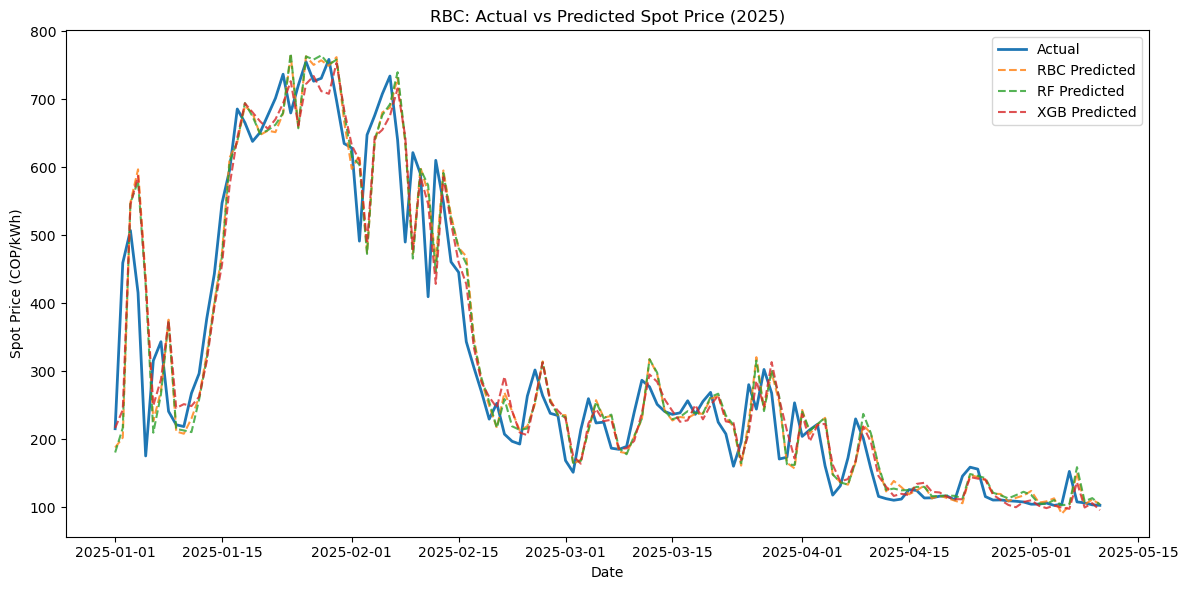

In [81]:
plt.figure(figsize=(12,6))
plt.plot(dates, y_test, label='Actual', linewidth=2)
plt.plot(dates, y_pred, label='RBC Predicted', alpha=0.8, linestyle='--')

plt.plot(dates, y_pred_rf, label='RF Predicted', alpha=0.8, linestyle='--')
plt.plot(dates, y_pred_xgb, label='XGB Predicted', alpha=0.8, linestyle='--')


plt.legend()
plt.title('RBC: Actual vs Predicted Spot Price (2025)')
plt.xlabel('Date')
plt.ylabel('Spot Price (COP/kWh)')
plt.tight_layout()
plt.show()

Maximum Error in COP/kWh: 255.76150517578125


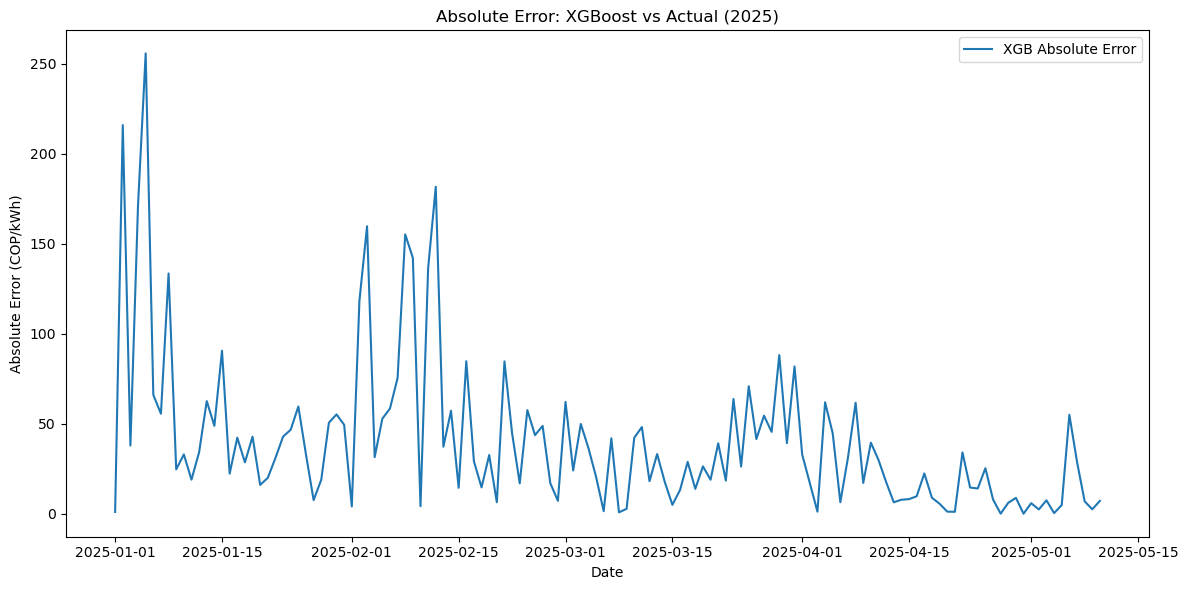

Maximum Perc Error: 145.53502423812
Minimum Perc Error: 0.003990300908561315


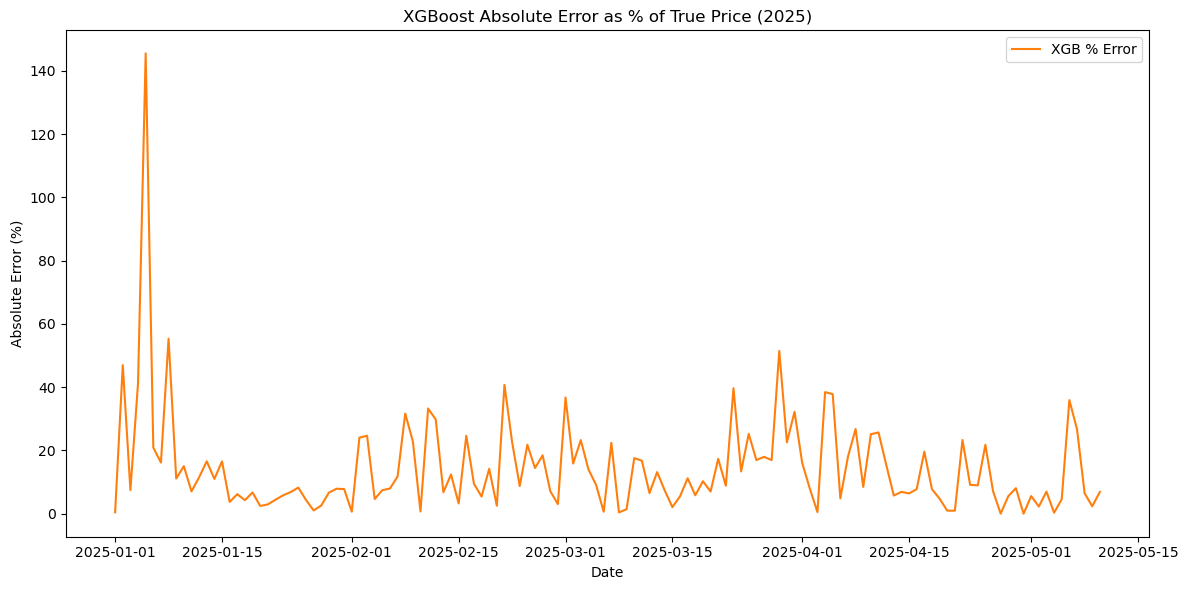

In [82]:
# 5) Compute absolute error for XGBoost
abs_error_xgb = np.abs(y_test - y_pred_xgb)
print(f'Maximum Error in COP/kWh: {max(abs_error_xgb)}')

# 6) Plot the absolute error over time
plt.figure(figsize=(12, 6))
plt.plot(dates, abs_error_xgb, label='XGB Absolute Error')
plt.legend()
plt.title('Absolute Error: XGBoost vs Actual (2025)')
plt.xlabel('Date')
plt.ylabel('Absolute Error (COP/kWh)')
plt.tight_layout()
plt.show()

# 7) Compute percent error
pct_error_xgb = abs_error_xgb / y_test * 100

print(f'Maximum Perc Error: {max(pct_error_xgb)}')
print(f'Minimum Perc Error: {min(pct_error_xgb)}')

# 8) Plot percent error over time
plt.figure(figsize=(12, 6))
plt.plot(dates, pct_error_xgb, label='XGB % Error', color='tab:orange')
plt.legend()
plt.title('XGBoost Absolute Error as % of True Price (2025)')
plt.xlabel('Date')
plt.ylabel('Absolute Error (%)')
plt.tight_layout()
plt.show()

# Correlation Plots

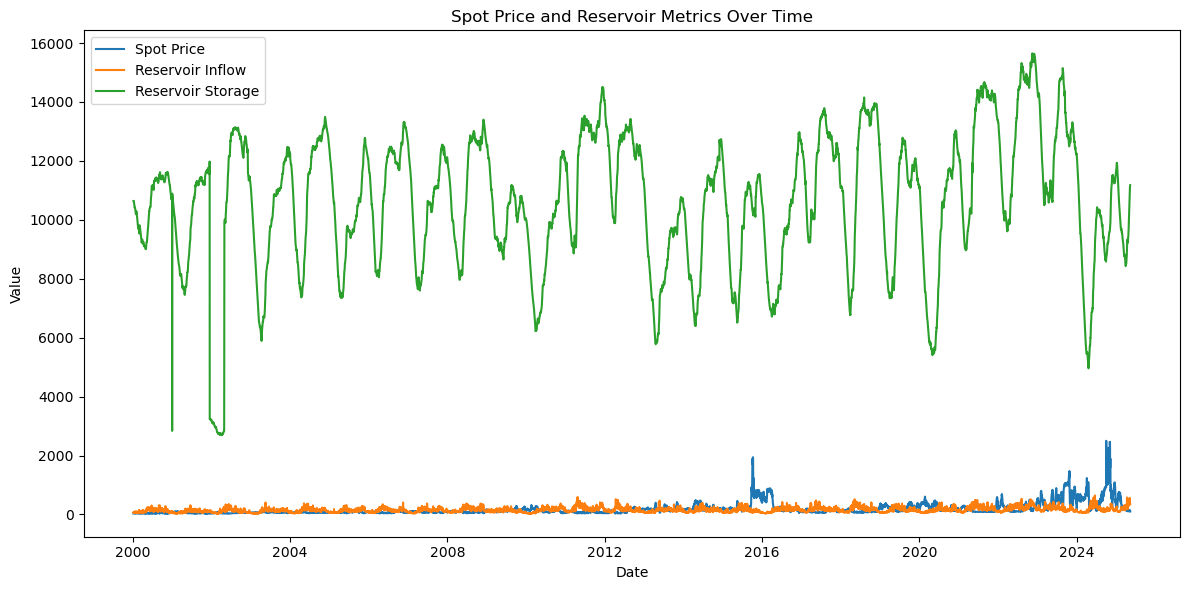

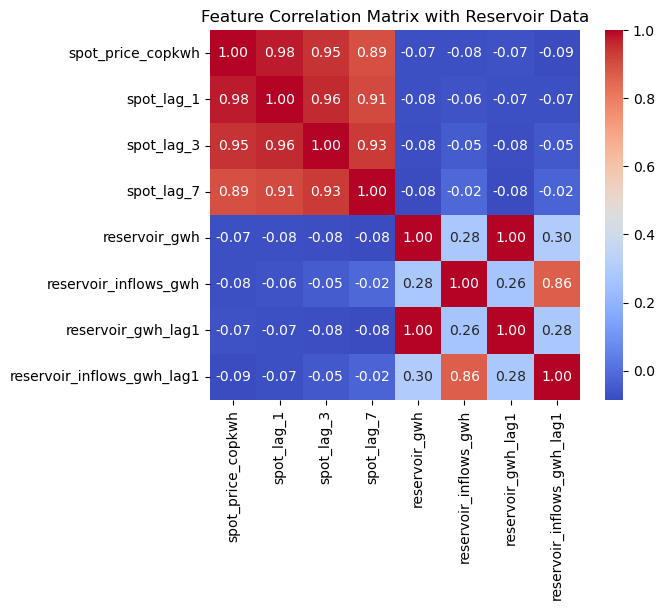

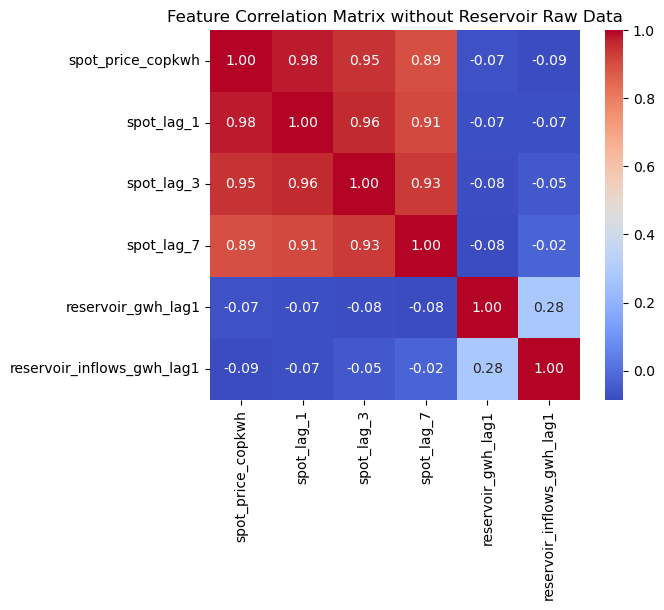

In [83]:
# Plotting features against time and each other
plt.figure(figsize=(12, 6))
plt.plot(df_model.index, df_model['spot_price_copkwh'], label='Spot Price')
plt.plot(df_model.index, df_model['reservoir_inflows_gwh'], label='Reservoir Inflow')
plt.plot(df_model.index, df_model['reservoir_gwh'], label='Reservoir Storage')
plt.legend()
plt.title('Spot Price and Reservoir Metrics Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

    
# Correlation matrices
corr_matrix = df_model[[
    'spot_price_copkwh', 
    'spot_lag_1','spot_lag_3','spot_lag_7', 
    'reservoir_gwh','reservoir_inflows_gwh', 
    'reservoir_gwh_lag1','reservoir_inflows_gwh_lag1'
]].corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix with Reservoir Data")
plt.show() 

# Correlation matrices
corr_matrix = df_model[[
    'spot_price_copkwh', 
    'spot_lag_1','spot_lag_3','spot_lag_7',
    'reservoir_gwh_lag1','reservoir_inflows_gwh_lag1'
]].corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix without Reservoir Raw Data")
plt.show()

# XGBOOST W/ RANDOMIZED SEARCH

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from xgboost import XGBRegressor

class XGBSklearnWrapper(BaseEstimator, RegressorMixin):
    def __init__(self,
                 n_estimators=200,
                 learning_rate=0.05,
                 max_depth=5,
                 subsample=0.8,
                 colsample_bytree=0.8,
                 gamma=0,
                 reg_alpha=0,
                 reg_lambda=1,
                 random_state=42):
        self.n_estimators    = n_estimators
        self.learning_rate   = learning_rate
        self.max_depth       = max_depth
        self.subsample       = subsample
        self.colsample_bytree= colsample_bytree
        self.gamma           = gamma
        self.reg_alpha       = reg_alpha
        self.reg_lambda      = reg_lambda
        self.random_state    = random_state

    def fit(self, X, y):
        # instantiate a fresh XGBRegressor with the current params
        self._model = XGBRegressor(
            n_estimators    = self.n_estimators,
            learning_rate   = self.learning_rate,
            max_depth       = self.max_depth,
            subsample       = self.subsample,
            colsample_bytree= self.colsample_bytree,
            gamma           = self.gamma,
            reg_alpha       = self.reg_alpha,
            reg_lambda      = self.reg_lambda,
            random_state    = self.random_state,
            tree_method     = 'hist',     # keep your speed tricks
            verbosity       = 0
        )
        self._model.fit(X, y)
        return self

    def predict(self, X):
        return self._model.predict(X)

Fitting 5 folds for each of 40 candidates, totalling 200 fits

Tuned XGB on 2025:
    Best params: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 1, 'colsample_bytree': 0.6}
    Best CV RMSE: 119.2915727779845
    RMSE : 58.02
    MAE  : 41.02
    SMAPE: 14.03%
    MASE : 1.120



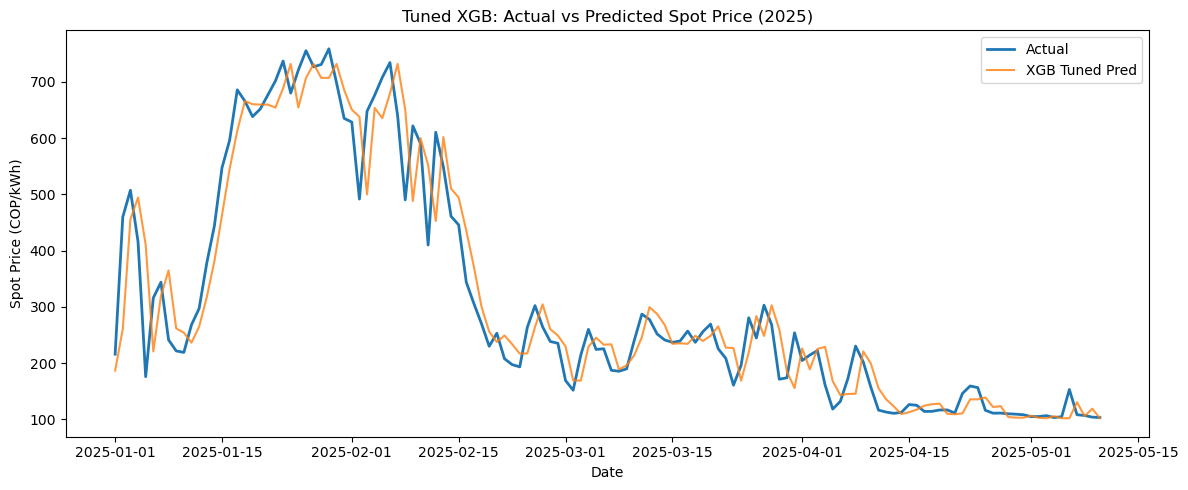

In [85]:
# 1) Prepare train/test split
df_model.index = pd.to_datetime(df_model.index)  # Add this only if not already datetime
train = df_model[(df_model.index.year >= 2020) & (df_model.index.year <= 2024)]
test  = df_model[df_model.index.year == 2025]

X_train = train[feature_cols]
y_train = train['spot_price_copkwh']
X_test  = test[feature_cols]
y_test  = test['spot_price_copkwh']
dates   = test.index

xgb = XGBSklearnWrapper()

param_dist = {
    'n_estimators':      [50, 100, 200, 300],
    'learning_rate':     [0.01, 0.05, 0.1, 0.2],
    'max_depth':         [3, 5, 7, 9],
    'subsample':         [0.6, 0.8, 1.0],
    'colsample_bytree':  [0.6, 0.8, 1.0],
    'gamma':             [0, 1, 5],
    'reg_alpha':         [0, 0.1, 1, 5],
    'reg_lambda':        [1, 2, 5, 10]
}

# 2) TimeSeriesSplit and RandomizedSearchCV as before
tscv = TimeSeriesSplit(n_splits=5)
rs = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=40,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rs.fit(X_train, y_train)


# evaluate on 2025 hold-out
best = rs.best_estimator_
y_pred = best.predict(X_test)


rmse_tuned = root_mean_squared_error(y_test, y_pred)   
mae_tuned  = mean_absolute_error(y_test, y_pred)

def smape(y_true, y_pred):
    num = np.abs(y_pred - y_true)
    den = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(num/den) * 100

def mase(y_true, y_pred, y_train):
    errors     = np.abs(y_true - y_pred)
    mae_model  = errors.mean()
    naive_errs = np.abs(np.diff(y_train))
    mae_naive  = naive_errs.mean()
    return mae_model / mae_naive

smape_tuned = smape(y_test.values,      y_pred)
mase_tuned  = mase(y_test.values, y_pred, train['spot_price_copkwh'].values)

# print("Best params:", rs.best_params_)
# print("Best CV RMSE:", -rs.best_score_)

print(f"""
Tuned XGB on 2025:
    Best params: {rs.best_params_}
    Best CV RMSE: {-rs.best_score_}
    RMSE : {rmse_tuned:.2f}
    MAE  : {mae_tuned:.2f}
    SMAPE: {smape_tuned:.2f}%
    MASE : {mase_tuned:.3f}
""")

# 7) Plot
plt.figure(figsize=(12,5))
plt.plot(dates, y_test,   label='Actual',        linewidth=2)
plt.plot(dates, y_pred,   label='XGB Tuned Pred', alpha=0.8)
plt.legend()
plt.title('Tuned XGB: Actual vs Predicted Spot Price (2025)')
plt.xlabel('Date')
plt.ylabel('Spot Price (COP/kWh)')
plt.tight_layout()
plt.show()



# XGBOOST on only lags

Although XGBoost is a great predictor, the percent error varies too much for me. A 140% error won't help anyone 

XGB (lags-only) 2025 Test RMSE: 59.85


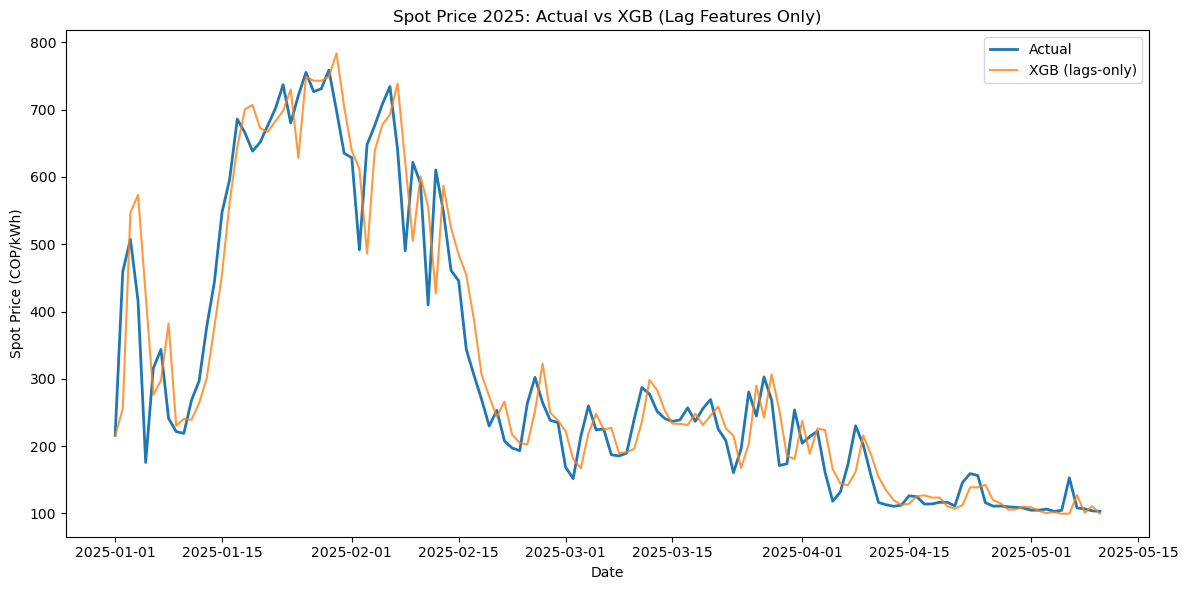

Maximum Error in COP/kWh: 250.03


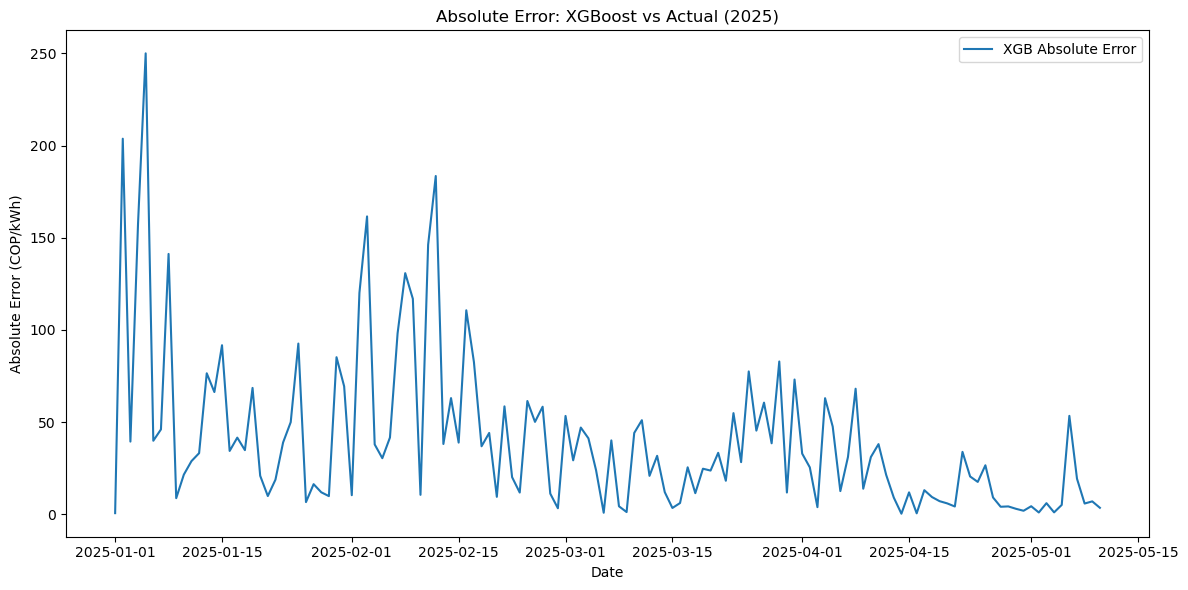

Maximum % Error: 142.27%
Minimum % Error: 0.25%


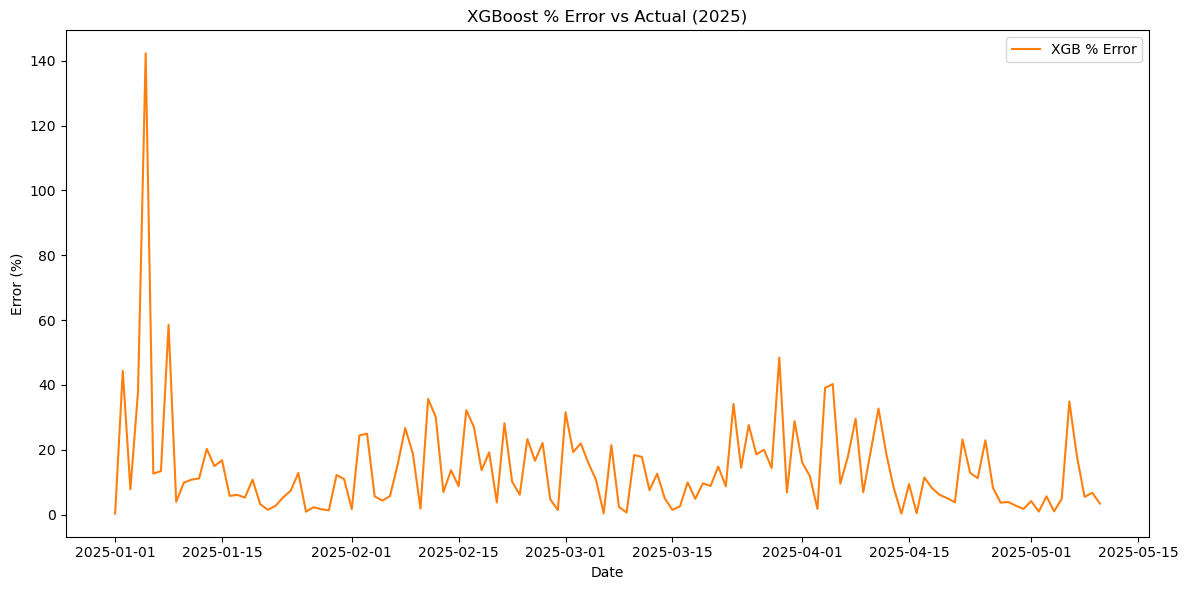

In [87]:
# Define the lag-only feature set
lag_features = ['reservoir_gwh_lag1', 'reservoir_inflows_gwh_lag1', 'spot_lag_1', 'spot_lag_3', 'spot_lag_7']

# Time-aware train/test split
train = df_model[(df_model.index.year >= 2020) & (df_model.index.year <= 2024)]
test  = df_model[df_model.index.year == 2025]

X_train_lags = train[lag_features]
X_test_lags  = test[lag_features]
y_train = train['spot_price_copkwh']
y_test  = test['spot_price_copkwh']
dates   = test.index

# XGBoost model on lag-only features
xgb_lag = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_lag.fit(X_train_lags, y_train)
y_pred_xgb = xgb_lag.predict(X_test_lags)
rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)
print(f"XGB (lags-only) 2025 Test RMSE: {rmse_xgb:.2f}")

# Plot predictions vs actual
plt.figure(figsize=(12,6))
plt.plot(dates, y_test, label='Actual', linewidth=2)
plt.plot(dates, y_pred_xgb, label='XGB (lags-only)', alpha=0.8)
plt.legend()
plt.title('Spot Price 2025: Actual vs XGB (Lag Features Only)')
plt.xlabel('Date')
plt.ylabel('Spot Price (COP/kWh)')
plt.tight_layout()
plt.show()

# Absolute error
abs_error_xgb = np.abs(y_test - y_pred_xgb)
print(f'Maximum Error in COP/kWh: {abs_error_xgb.max():.2f}')

plt.figure(figsize=(12,6))
plt.plot(dates, abs_error_xgb, label='XGB Absolute Error')
plt.legend()
plt.title('Absolute Error: XGBoost vs Actual (2025)')
plt.xlabel('Date')
plt.ylabel('Absolute Error (COP/kWh)')
plt.tight_layout()
plt.show()

# Percent error
pct_error_xgb = abs_error_xgb / y_test * 100
print(f'Maximum % Error: {pct_error_xgb.max():.2f}%')
print(f'Minimum % Error: {pct_error_xgb.min():.2f}%')

plt.figure(figsize=(12,6))
plt.plot(dates, pct_error_xgb, label='XGB % Error', color='tab:orange')
plt.legend()
plt.title('XGBoost % Error vs Actual (2025)')
plt.xlabel('Date')
plt.ylabel('Error (%)')
plt.tight_layout()
plt.show()
